These notes follow "The Metropolis-Hastings algorithm" (C.P. Robert, 2016).

Monte Carlo methods encompass a large family of sampling-based numerical integration techniques.

Several of these are based on Markov chain theory. These are Markov chain Monte Carlo (MCMC) techniques. One such variant is the Metropolis-Hastings algorithm.



Consider a state space $\mathcal{X}$ upon which a probability density $\pi$ is defined. Assume that $\pi$ is computable up to a multiplicative constant, i.e., $$ \pi\left(x\right) \propto \tilde{\pi}\left(x\right) $$
Metropolis-Hastings is a method for constructing an ergodic Markov chain on $\mathcal{X}$ which is stationary with respect to $\pi$: $$ X^{\left(t\right)} \sim \pi \left(x\right) \; \implies \; X^{\left(t+1\right)} \sim \pi \left(x\right) $$ It follows that this Markov chain converges (in distribution) to $\pi$.

Why do we need such a method? 
> "They provide shortcuts in cases where generic sampling requires too much effort from the experimenter."

This refers to a simple approach such as grid sampling, which suffers from the so-called "curse of dimensionality."

We start with the target density $\pi$ which we want to find. We must choose a conditional proposal density $q$ such that the transition from the Markov chain value $X^{\left(t\right)}$ to $X^{\left(t+1\right)}$ is governed by the steps

1. Generate $Y_t \sim q\left(y\,\middle|\,x^{\left(t\right)}\right)$
2. Assign $$ X^{\left(t+1\right)} = \left\{ \begin{array}{lc} Y_t & \text{with probability} \; p\left(x^{\left(t\right)},Y_t\right) \\ x^{\left(t\right)} &  \text{with probability} \; 1-p\left(x^{\left(t\right)},Y_t\right) \end{array}\right. $$

The proposal density $q$ is where the $Y_t$ value comes from, which is used both to make the decision and also may be the next value $X^{\left(t+1\right)}$. The distribution $q$ of $y$ is conditional on the current value $X^{\left(t\right)}$, which is where the notion of Markov chain comes from. The probability in the decision is defined as $$ p\left(x,y\right) = \min \left\{ \frac{\tilde{\pi}\left(y\right)}{\tilde{\pi}\left(x\right)} \frac{q\left(x\,\middle|\,y\right)}{q\left(y\,\middle|\,x\right)}, 1\right\} $$

In the original paper, by Metropolis (1953), this transition update step preserves the stationary density $\pi$ if the chain is irreducible (i.e., if $q$ has wide enough support so that we can reach any region of $\mathcal{X}$ with positive mass under $\pi$). This is particularly interesting since we started with an arbitrary choice of density $q$ and this update preserves $\pi$ as the stationary distribution. In pratice, we must choose $q$ wisely to ensure feasible convergence. 

In [25]:
import numpy as np
import matplotlib.pyplot as plt 
from numpy.random import normal, uniform

In [200]:
# target: mult const perturbed normal
def target(x): 
    return (np.sin(x)**2) * (np.sin(2*x)**2) * np.exp(-0.5*(x**2))

def metropolis_step(x, alpha=1):
    y = uniform(x-alpha, x+alpha, size=1) # kernel is used here
    z = uniform(0,1,1)
    if np.log(z) < np.log(target(y)) - np.log(target(x)):
        return y
    else:
        return x



In [201]:
x = np.pi
y = uniform(x-1,x+1,1)
print("x = ",x)
print("y = ",y[0])
print("target(x) = ", target(x))
print("target(y) = ", target(y)[0])

x =  3.141592653589793
y =  3.6589437609502213
target(x) =  6.470622048153808e-66
target(y) =  0.00022389160130408553


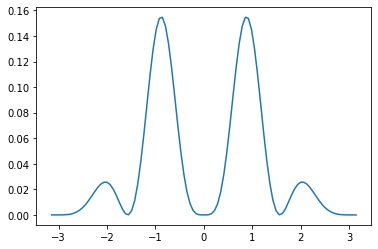

In [202]:
t = np.linspace(-np.pi, np.pi, num=100)
plt.plot(t,pi_tilde(t))

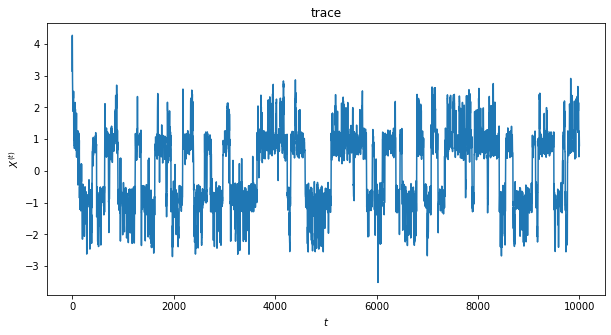

In [215]:
trace = np.repeat(np.pi-0.01, 10**4)
trace[0] = np.pi
for j in range(1,len(trace)):
    trace[j] = metropolis_step(trace[j-1])

plt.figure(figsize=(10,5))
plt.plot(trace[:])
plt.title("trace")
plt.xlabel(r"$t$")
plt.ylabel(r"$X^{\left(t\right)}$")
plt.show()

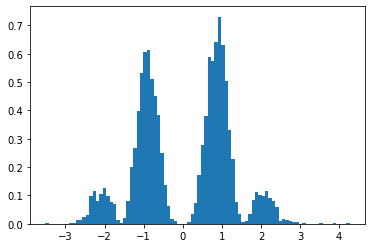

In [218]:
plt.hist(trace,bins=90, density=True);

Now, if we adjust the $\alpha$ parameter, which controls the width of the kernel, we can control how likely we are to move around in the space. For instance, if we shrink $\alpha$, then we are limiting the extent of the uniform distribution from which we draw $Y_t$, which, recall, is our candidate for the next state value $X^{\left(t+1\right)}$.

As we make $\alpha$ smaller, we see that the trace is more likely to stay closer to one or only a few of the peaks (modes) in the distribution.

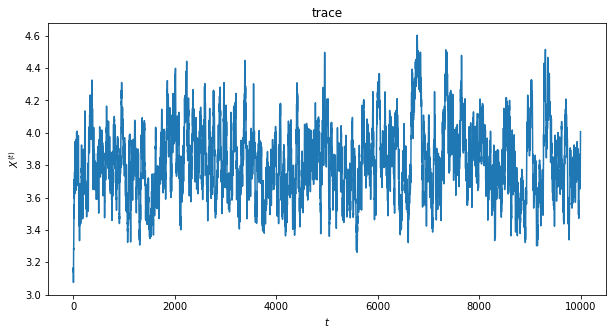

In [228]:
trace = np.repeat(np.pi-0.01, 10**4)
trace[0] = np.pi
for j in range(1,len(trace)):
    trace[j] = metropolis_step(trace[j-1], alpha=0.1)

plt.figure(figsize=(10,5))
plt.plot(trace[:])
plt.title("trace")
plt.xlabel(r"$t$")
plt.ylabel(r"$X^{\left(t\right)}$")
plt.show()

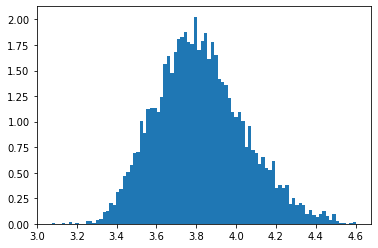

In [229]:
plt.hist(trace,bins=90, density=True);

# Questions to answer
* What exactly is this algorithm for? It says it is for numerical integration, but it looks like we simply are sampling from a particular distribution, which we already know (apart from the normalization constant). How does this help us?
* This seems far too straightforward to be useful. In comparison, Gibbs sampling requires a large amount of analytical preparation in devising the update equations. Why would we use one over the other?
* A difficulty in practice seems to be calibration (determining the hyperparameters such as $\alpha$).
* What is HMC? It is a physics-based alternative which uses a momentum notion to allow the chain to reach distant regions, thus preventing the chain (in part?) from performing too locally, as the Metropolis-Hastings approach, above, did.